This program implements a basic momentum-based portfolio trading strategy in Python, using the yfinance package to fetch historical data from Yahoo Finance, and pandas and numpy for data manipulation.

In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# Define the list of stocks in your portfolio
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META']

# Define the period for which to fetch the stock data
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch the stock data
data = yf.download(stocks, start=start_date, end=end_date)['Close']
sp500 = yf.download('^GSPC', start=start_date, end=end_date)


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


Need to resample the data to monthly frequency using forward filling to fill any missing values. Then, it calculates the percentage change in the prices to get the returns.

In [8]:
# Calculate the monthly price of the stocks
data_monthly = data.resample('M').ffill() # Use forward filling
returns = data_monthly.pct_change()

The 'calculate_momentum' function takes two input parameters, 'x' and 'period'. It calculates the momentum value of a given series 'x' by dividing the value of 'x' at a specific time period with the value of 'x' at a shifted time period. It then subtracts 1 from the result and returns the momentum value.

The 'calculate_portfolio_weights' function takes a DataFrame 'df' as input. It calculates the ranks of each stock in 'df' based on their momentum. It creates a mask of stocks to be included in the portfolio by checking which stocks have ranks less than or equal to 3. It then calculates the portfolio weights by dividing the mask by the sum of the mask along the rows. Finally, it returns the portfolio weights.

In [31]:
# Function to calculate momentum
def calculate_momentum(x, period):
    return (x.shift() / x.shift(period)) - 1

# Calculate portfolio allocation
def calculate_portfolio_weights(df):
    # Calculate momentum ranks
    ranks = df.rank(axis=1, ascending=False)
    
    # Create a mask of stocks to be included in the portfolio
    mask = ranks<=3

    # Calculate portfolio weights
    portfolio_weights = mask.divide(mask.sum(axis=1), axis=0)
    return portfolio_weights


We calculate the portfolio returns based on the momentum of stocks. We first apply the momentum function to the returns of stocks using a specific time period. Then, we calculate the portfolio weights based on the ranks of stocks' momentum. Finally, we calculate the portfolio returns by multiplying the portfolio weights with the returns and summing them along the rows. The resulting portfolio returns are printed.


In [32]:

# Apply the momentum function to the returns
momentum = returns.apply(calculate_momentum, args=(6,))

# Calculate portfolio weights
portfolio_weights = calculate_portfolio_weights(momentum)

# Calculate portfolio returns
portfolio_returns = (portfolio_weights * returns).sum(axis=1)


Finds the rolling Sharpe Ratio and maximum drawdown over a 12 month period, and the cumulative return of the portfolio.

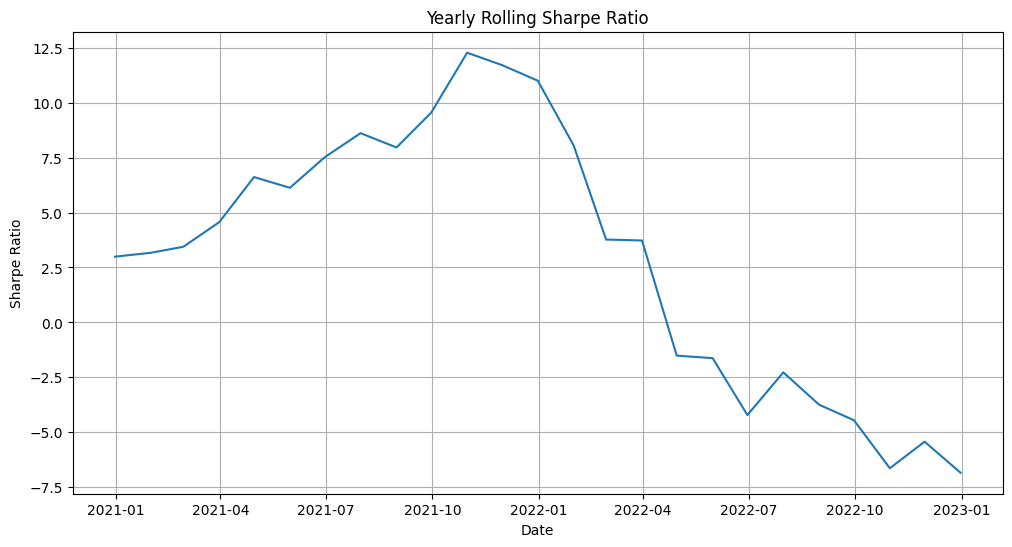

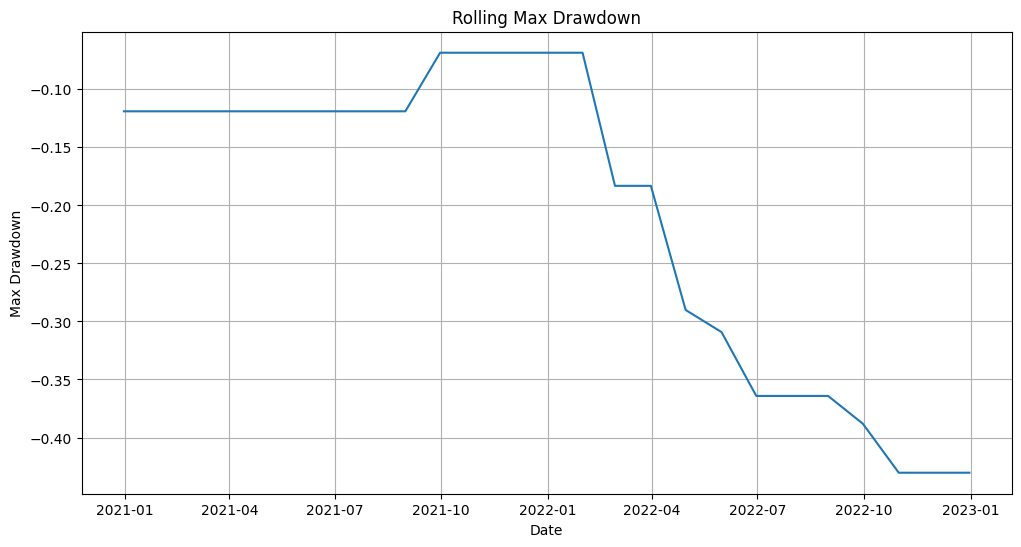

[*********************100%***********************]  1 of 1 completed


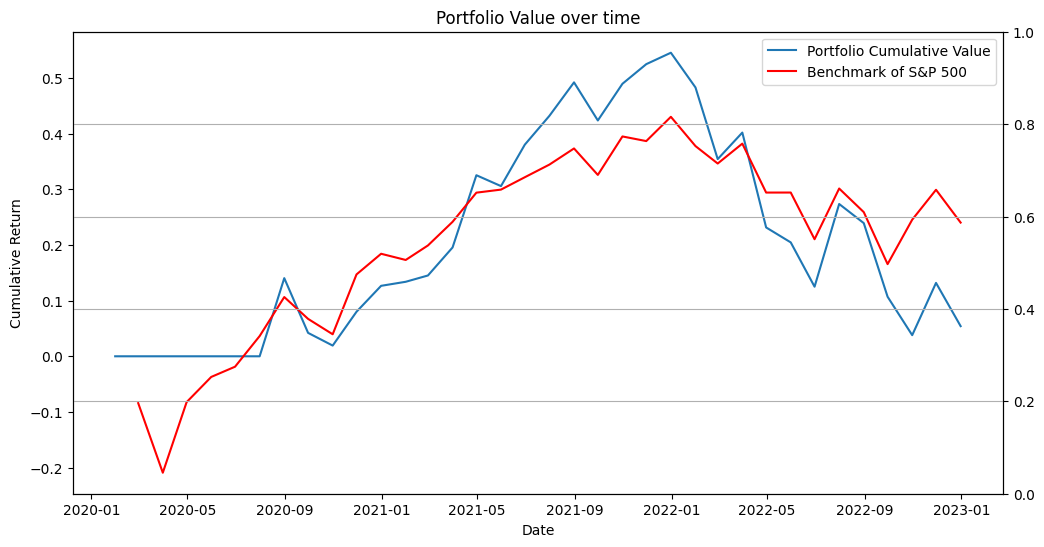

In [40]:
import matplotlib.pyplot as plt
import empyrical

# Calculate rolling metrics
window =   12
rolling_sharpe_ratio = portfolio_returns.rolling(window).apply(empyrical.sharpe_ratio)
rolling_max_drawdown = portfolio_returns.rolling(window).apply(empyrical.max_drawdown)
portfolio_returns_cum = portfolio_returns.cumsum()

# Plot rolling Sharpe Ratio
plt.figure(figsize=(12, 6))
plt.plot(rolling_sharpe_ratio)
plt.title('Yearly Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

# Plot rolling Drawdown
plt.figure(figsize=(12, 6))
plt.plot(rolling_max_drawdown)
plt.title('Rolling Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.grid(True)
plt.show()

# Plot rolling Monthly Returns with the average return if we invested in all 5 and held.
# first find returns from s&p 500:
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500['Close'].resample('M').ffill()
sp500_returns = sp500.pct_change()
fig,ax = plt.subplots(figsize = (12,6))

ax.plot(portfolio_returns_cum,label = 'Portfolio Cumulative Value')

ax.set_title('Portfolio Value over time')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax1 = ax.twinx()
ax.plot(sp500_returns.cumsum(),'r-',label = 'Benchmark of S&P 500')
ax.legend()
plt.grid(True)
plt.show()
